# OLX Data Science Assignment

Hi!

You're probably wondering what to expect and how to make sense of what's being done here. Since notebooks were the preferred way of delivering the solution, there aren't any elaborate pipelines done, but rather some methods I was reusing throughout the project or just using them to organize code. Other than that, standard exploratory analysis and code written and executed sequentially. 

While there's a lot of additional stuff I could do with the data, I just wasn't sure whether getting rid of outliers was ok or not (that's removing some data after all), and how much data manipulation was allowed. So I didn't remove them and didn't change their values.

One more approach I always like to take with tasks like these is sacrificing some performance for the sake of analysis and exploration of different methods and techniques, as well as more model analysis, and explaining its performance. I certainly could focus all my efforts on tweaking model's hyperparameters and doing something more sophisticated, be it stacking models, blending them or adding neural network meta learners, but time I can devote for this task is somewhat limited.

One more thing I didn't do here is normalizing and trimming train data to the values of test data. While often done in kaggle competitions, it's not really a good practice and I see no point in doing that.

If You'd like to run this notebook, use the following command (using anaconda) to create a new environment with all the libraries I used and You should be good to go:

`conda create -n recruitment_task python=3.8.6 pandas seaborn scipy scikit-learn lightgbm shap`

## Initial look

In [1]:
import math
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.special import boxcox1p

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

import shap

#options and constants
RAND_SEED = 7

pd.options.display.max_columns = 35
pd.options.display.max_rows = 20

In [2]:
data_path = "otomoto_price_prediction_data.csv"
raw_data = pd.read_csv(data_path)

Let's look at the dataset real quick.

Typically, at this stage of the project, I'm looking for some ideas about which features I should focus on and maybe do some more research on how are they tied specifically to the problem I'm presented with. That would most often boild down to:
- usage of external data,
- feature selection,
- feature engineering (both "synthetic" which I'll explain later and a little bit more creative one),
- domain knowledge,

and possibly more, depending on the specifities of data and how in-depth I want to get.

In [3]:
raw_data.head(5)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,audi,a6,2013,153817.0,1984.0,180.0,automatic,petrol,0,0,69900.0
1,skoda,fabia,2004,115000.0,1390.0,75.0,manual,petrol,0,1,8299.0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,automatic,petrol,0,1,54500.0
3,bmw,seria-3,2013,155000.0,1995.0,163.0,automatic,diesel,0,0,62000.0
4,renault,talisman,2017,167000.0,1600.0,130.0,automatic,diesel,0,1,52999.0


In [4]:
print(f"The dataset consists of {raw_data.shape[0]} rows and {raw_data.shape[1]} columns")

The dataset consists of 206207 rows and 11 columns


We know that the data was from Otomoto.pl but not when the dataset was prepared. A quick look at the site tells us, that currently there are 205794 listings (just over 400 less), so the data must be relatively "fresh". It's also reinforced by the fact that there are 2020 and 2021 model year vehicles in the data.  

Since there was also a short description attached, we know what each of the features means (although they are rather self-explanatory). It's clear that we can do a lot of neat stuff with this and given a litle bit of domain knowledge on my side, we can come up with a few interesting takeaways and features.

Let's take a closer look at data's properties and features.  

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206207 entries, 0 to 206206
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             206207 non-null  object 
 1   model            206207 non-null  object 
 2   vehicle_year     206207 non-null  int64  
 3   mileage          204853 non-null  float64
 4   engine_capacity  204029 non-null  float64
 5   engine_power     204628 non-null  float64
 6   gearbox          204842 non-null  object 
 7   fuel_type        206207 non-null  object 
 8   damaged          206207 non-null  int64  
 9   is_business      206207 non-null  int64  
 10  target_price     206207 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 17.3+ MB


Fortunately, there's not a lot of missing data; some of the features can be simplified as well (e.g. engine_capacity) and some data types can be changed to improve performance.

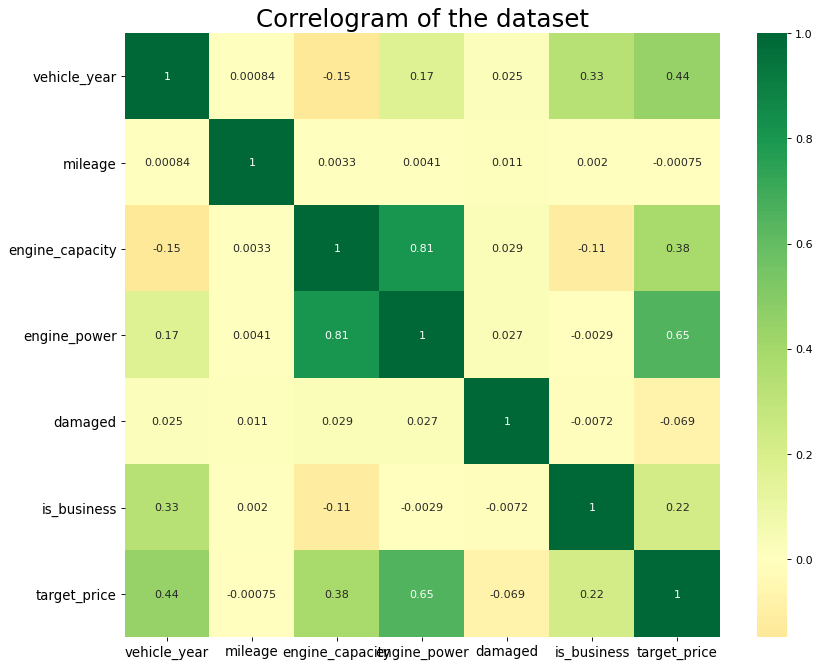

In [6]:
def draw_correlogram(data, correlation_type='spearman', corr_values=True):
    correlations = data.corr()
    plt.figure(figsize=(12,10), dpi= 80)
    sns.heatmap(correlations, xticklabels=correlations.columns, 
                yticklabels=correlations.columns, cmap='RdYlGn', 
                center=0, annot=corr_values)

    plt.title('Correlogram of the dataset', fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

draw_correlogram(raw_data)

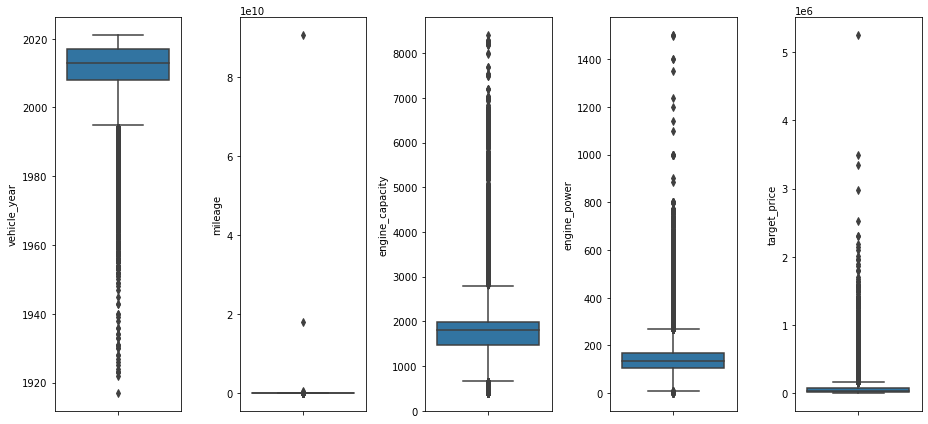

In [7]:
quantitative = ['vehicle_year', 'mileage', 'engine_capacity', 'engine_power', 'target_price']

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(13, 6))
index = 0
axs = axs.flatten()
for k,v in (raw_data[quantitative].notnull()).items():
    sns.boxplot(y=k, data=raw_data, ax=axs[index])
    index = index + 1
plt.tight_layout()

Clearly there are some outliers in our data with which we'll deal later on. Now let's start the process of cleaning the data and making it ready for analysis.

## Data preprocessing

### Dealing with missing data

In [8]:
def check_nulls(data):
    return pd.DataFrame({"values_null": data.isnull().sum(),
                         "percentage_null": data.isnull().sum() / data.shape[0] * 100})
    
check_nulls(raw_data) 

,values_null,percentage_null
make,0,0.000000
model,0,0.000000
vehicle_year,0,0.000000
mileage,1354,0.656622
engine_capacity,2178,1.056220
engine_power,1579,0.765735
gearbox,1365,0.661956
fuel_type,0,0.000000
damaged,0,0.000000
is_business,0,0.000000


To better understand what data is missing and whether we can come up with some imputation strategy based on other values, let's take a look at the missing values heatmap.

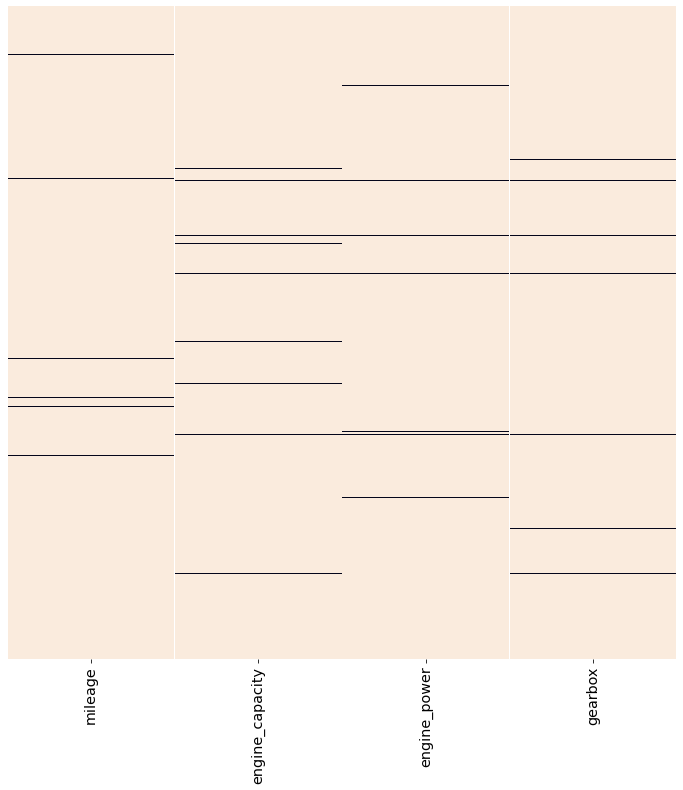

In [9]:
cols_with_missing_data = ['mileage', 'engine_capacity', 'engine_power', 'gearbox']

plt.figure(figsize=(12,12))
sns.heatmap(~raw_data[cols_with_missing_data].isnull(), cbar=False, yticklabels=False)
plt.xticks(rotation=90, size='x-large')
plt.show()

Looking at the heatmap, there are a couple of takeaways:
- missing `mileage` doesn't appear to be related to any other missing data, which can be easily imputed or explained when we look at `vehicle_year` values for these records, as new vehicles could be imputed with 0s,
- there are some instances where `engine_capacity`, `engine_power` and `gearbox` values are all missing concurrently, which could be hard to impute without introducing additional bias to the data (there are many different equipment options and packages even within the same model range).
- the rest of missing `engine_capacity`, `engine_power` and `gearbox` values can be easily imputed if any of the other aren't missing at the same time. In conjunction with `make`, `model` and `vehicle_year`, we can take an educated guess, since there aren't that many power & capacity combinations within the same manufacturer.
- to follow up the above point, there's no fear of excessive bias in case of modified cars, since these modifications rarely make the price go that much higher. Furthermore, we'll start with `engine_capacity`, `gearbox` and then `engine_power`, since it's much more expensive and complicated to modify the two former, which means there'll be less deviations and potential bias in our imputation.

#### Mileage

Let's look at missing mileage first and see if our assumptions were correct.

In [10]:
raw_data[raw_data['mileage'].isnull()]['vehicle_year'].value_counts(normalize=True)

2020    0.932053
2021    0.045790
2019    0.022157
Name: vehicle_year, dtype: float64

Looks like we were right! All of the cars with missing mileage are pretty much new and it's not uncommon to see a one or two year old car still sitting brand new in the car lot. Let's also check if the seller is in fact business - that would give us a high confidence in our hypothesis.

In [11]:
raw_data[raw_data['mileage'].isnull()]['is_business'].value_counts(normalize=False)

1    1354
Name: is_business, dtype: int64

Looks like once again, we took a good guess. Let's fill in these values with 0s, since even if they aren't exacly 0, anything up to say 50km would be considered delivery mileage by the dealer anyways.

In [12]:
raw_data['mileage'] = raw_data['mileage'].mask((raw_data['mileage'].isnull()), 0)

#### Concurrently missing data

Let's see what the data looks like, if there are missing values in all of the considered columns. 

In [13]:
all_null_mask = (raw_data['engine_capacity'].isnull()) & (raw_data['engine_power'].isnull()) & (raw_data['gearbox'].isnull())
any_null_mask = (raw_data['engine_capacity'].isnull()) | (raw_data['engine_power'].isnull()) | (raw_data['gearbox'].isnull())

print(f"There are {raw_data[any_null_mask].shape[0]} records with some null values left (including potential unions).")

There are 2965 records with some null values left (including potential unions).


In [14]:
raw_data[any_null_mask].head(5)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
243,audi,a5,2008,217000.0,NaN,NaN,NaN,diesel,0,0,35999.0
353,mini,clubman,2018,25500.0,NaN,NaN,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0
413,opel,zafira,2009,189000.0,1800.0,140.0,NaN,petrol,0,1,18500.0
473,mazda,6,2014,62000.0,NaN,NaN,NaN,petrol,0,0,45500.0


First, to make our work a little faster and easier, let's manually mask electric cars with null `engine_capacity` as 0s. We don't have any better solution since it's not possible to estimate it off of some other feature. Additionally, some of the electric cars have wrongly labeled engine capacities, we'll kill two birds with one stone and set all of the electric cars `engine_capacity` to 0.

In [15]:
raw_data['engine_capacity'] = raw_data['engine_capacity'].mask((raw_data['fuel_type'] == 'electric'), 0)

Now, for each of the records, we'll find what the most common values are for `engine_capacity`, `engine_power` and `gearbox` for the same `make`, `model`, `fuel_type` and `vehicle_year` within +- 1 year. While not the perfect solution, it's definitely better than just imputing the most common value from all of the data. 

We'll also save the indexes of the data we were imputing, to check if we imputed something that wouldn't make sense. 

For example, let's take a look at the first car in the output above - Audi A5 from 2008 with a diesel engine and see what's the most frequent engine capacity:

In [16]:
correctness_check_index = raw_data[any_null_mask].index

search_mask = ((raw_data['make'] == 'audi') & 
               (raw_data['model'] == 'a5') & 
               (raw_data['vehicle_year'] == 2008) & 
               (raw_data['fuel_type'] == 'diesel'))
result_value = raw_data[search_mask]['engine_capacity'].value_counts(dropna=True).index[0]
result_value

2698.0

Generally speaking, iterating over dataframe's rows is a really bad idea (the performance hit), but what we're trying to do here is a an example of a perfectly fine reason to want to iterate over a dataframe: we want to execute some code using the values of each row as input (which would be necessary for a search mask unique to every single row with null values. 

In this case, we'll use indexes (to speed things up a bit) and try to limit the number of data needed as soon in the process as possible.

In [17]:
def impute_by_most_freq(dataset, colname, data_to_impute_index, error_impute_value):
    
    for index in data_to_impute_index:
        col_index = dataset.columns.get_loc(colname)
        current_search_mask = ((dataset['make'] == dataset['make'][index]) & 
                               (dataset['model'] == dataset['model'][index]) & 
                               (dataset['vehicle_year'] <= (dataset['vehicle_year'][index] + 1)) & 
                               (dataset['vehicle_year'] >= (dataset['vehicle_year'][index] - 1)) &
                               (dataset['fuel_type'] == dataset['fuel_type'][index]))
        
        current_result_val = dataset[current_search_mask][colname].value_counts(dropna=True)
        try:
            most_freq_val = current_result_val.index[0]
        except IndexError:
            most_freq_val = error_impute_value
        
        dataset.iat[index, col_index] = most_freq_val   

In [18]:
impute_by_most_freq(raw_data, 'engine_capacity', raw_data[raw_data['engine_capacity'].isnull()].index, 0)
impute_by_most_freq(raw_data, 'engine_power', raw_data[raw_data['engine_power'].isnull()].index, 0)
impute_by_most_freq(raw_data, 'gearbox', raw_data[raw_data['gearbox'].isnull()].index, 'not_found')

Now that all the null values are dealt with, let's move on to the data preprocessing. 

## Preprocessing and feature transformation

Now that missing values are dealt with, we need to make the remaining data as simple as possible, without adding bias or removing variance. First, to pick up right where we left off, let's try to simplify `gearbox` values.

In [19]:
raw_data.head(3)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,audi,a6,2013,153817.0,1984.0,180.0,automatic,petrol,0,0,69900.0
1,skoda,fabia,2004,115000.0,1390.0,75.0,manual,petrol,0,1,8299.0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,automatic,petrol,0,1,54500.0


In [20]:
raw_data['gearbox'].value_counts(normalize=True)*100

manual                           65.236389
automatic                        32.693846
dual-clutch                       1.131387
cvt                               0.846722
semi-automatic                    0.040251
not_found                         0.025217
automatic-stepless                0.015033
automatic-sequential              0.004365
automated-manual                  0.003395
automatic-stepless-sequential     0.002910
manual-sequential                 0.000485
Name: gearbox, dtype: float64

It's evident that values less frequent than CVT transmissions are basically early versions of automatic, so we can simplify those and not loose too much signal in our data.

In [21]:
automatic_like = ['semi-automatic', 'automatic-stepless', 'automatic-sequential', 'not_found', 
                  'automated-manual', 'automatic-stepless-sequential', 'manual-sequential']

gearbox_index = raw_data[raw_data['gearbox'].isin(automatic_like)].index

for index in gearbox_index:
    raw_data.iat[index, 6] = 'automatic'

The only other feature we can simplify is fuel_type. Let's take a look.

In [22]:
raw_data['fuel_type'].value_counts(normalize=True)*100

petrol        50.300426
diesel        42.515046
petrol-lpg     4.197239
hybrid         2.476153
electric       0.482040
petrol-cng     0.028612
etanol         0.000485
Name: fuel_type, dtype: float64

We'll delete etanol-based car at the very end since all of the values in that record are outliers anyways and leave the rest intact, since they can have some impact on target price (cng-based cars are different from the factory)

## Checking out target variable

An important part of the regression task is to check the target variable's distribution. If it doesn't follow normal, we can transform it accordingly. It's done mainly because some algorithms which we may end up using, expect the values to follow a normal distribution, while others don't care and most likely won't worsen the performance anyways.

In [23]:
def draw_hist_qq(data, target, do_log_transform=False):
    if do_log_transform:
        target = np.log1p(data[target])
    else:
        target = data[target]

    sns.distplot(target, fit=stats.norm)
    (mu, sigma) = stats.norm.fit(target)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Feature distribution')

    fig = plt.figure()
    res = stats.probplot(target, plot=plt)
    plt.show()

    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


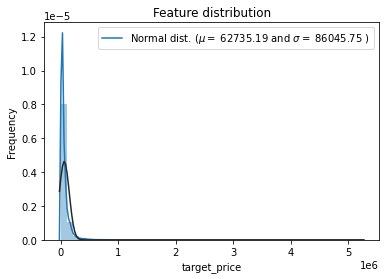

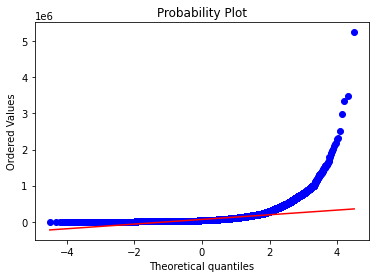


 mu = 62735.19 and sigma = 86045.75



In [24]:
draw_hist_qq(raw_data, 'target_price', do_log_transform=False)

As You can see, without any modifications, the distribution isn't even close to being normal. There appear to be some outliers on the top end as well. Let's see if a log transformation makes a difference.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


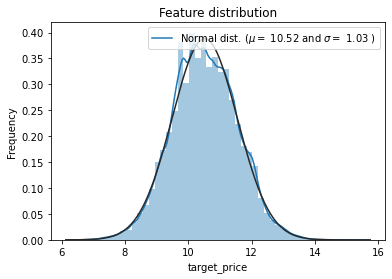

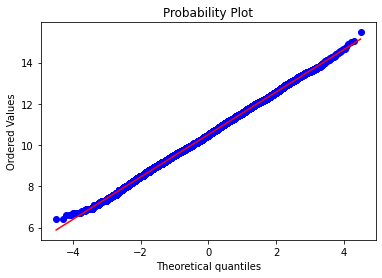


 mu = 10.52 and sigma = 1.03



In [25]:
draw_hist_qq(raw_data, 'target_price', do_log_transform=True)

It indeed does! Looks like the outliers aren't even as extreme as we thought in the first place. QQ plot tells us, that we're now dealing with almost perfect normally distributed data.

Normally, I would either use interquartile ranges to delete outliers, or if the data is normally distributed I would use a 3-sigma rule, however it looks as if it's not neccessary in this case.

While we're at it, let's check the correlation with our target variable, before we make any changes to the data or perform feature engineering (we'll revisit this later). Throughout the notebook, we'll most likely use Spearman correlation, as it has a chance of picking up non-linear relationships in data (unlike Pearson).

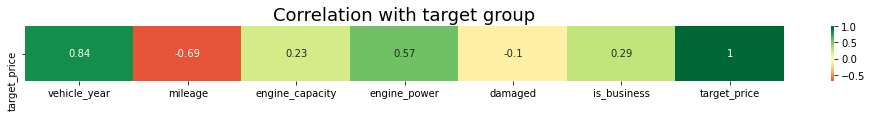

In [26]:
target_corr = raw_data.corr('spearman')
f,ax = plt.subplots(figsize=(17,1))
sns.heatmap(target_corr.sort_values(by=['target_price'], ascending=False).head(1), 
            cmap='RdYlGn', center=0, annot=True)
plt.title("Correlation with target group", fontsize=18)

plt.show()

Looks like we have some decent correlation with `target_price` and pretty much all the features are somewhat important, except for `damaged` - I suspect due to the fact that not many cars are damaged (relatively speaking). 

In [27]:
damaged_cars_pct = (raw_data[raw_data['damaged'] == 1].shape[0] / raw_data.shape[0]) * 100
print(f"Percent of cars listed as damaged: {round(damaged_cars_pct, 3)}")

Percent of cars listed as damaged: 3.806


## Quantitative features - outliers

Now, since there are some feautres that look like outliers, we'll have to decide what to do with these. In general, I wouldn't want to correct outliers in target variable, since we would be prone to introducing too much bias into our predictions. 

Let's write a little piece of code to see how much data we would loose if we were to delete outliers using interquartile ranges without any in-depth analysis. 

In [28]:
def remove_outliers(data, column, degree):
    quartile_1 = np.percentile(data[column], 25)
    quartile_3 = np.percentile(data[column], 75)
    interquartile_range = quartile_3 - quartile_1
    cut_off = interquartile_range * degree
    lower_bound, upper_bound = quartile_1 - cut_off, quartile_3 + cut_off
    dataset_size = data.shape[0]
    outliers = [x for x in data[column] if x < lower_bound or x > upper_bound]
    data = data.drop(data[(data[column] > upper_bound) | (data[column] < lower_bound)].index)

    print(f'{column.title()} outliers in total: {len(outliers)}, data loss: {(len(outliers)/dataset_size)*100}%')
    return data

In [29]:
no_outliers_df = remove_outliers(raw_data, 'target_price', 3.5)
print(f"The dataset would consist of {no_outliers_df.shape[0]}")

Target_Price outliers in total: 5065, data loss: 2.456269670767724%
The dataset would consist of 201142


In [30]:
no_outliers_df = remove_outliers(raw_data, 'engine_capacity', 3.5)
print(f"The dataset would consist of {no_outliers_df.shape[0]}")

Engine_Capacity outliers in total: 5362, data loss: 2.600299698846305%
The dataset would consist of 200845


In [31]:
no_outliers_df = remove_outliers(raw_data, 'engine_power', 3.5)
print(f"The dataset would consist of {no_outliers_df.shape[0]}")

Engine_Power outliers in total: 4144, data loss: 2.0096310988472745%
The dataset would consist of 202063


In [32]:
no_outliers_df = remove_outliers(raw_data, 'mileage', 3.5)
print(f"The dataset would consist of {no_outliers_df.shape[0]}")

Mileage outliers in total: 77, data loss: 0.037341118390743284%
The dataset would consist of 206130


In [33]:
no_outliers_df = remove_outliers(raw_data, 'vehicle_year', 3.5)
print(f"The dataset would consist of {no_outliers_df.shape[0]}")

Vehicle_Year outliers in total: 506, data loss: 0.24538449228202727%
The dataset would consist of 205701


If we were to blindly apply the outlier removal method, we would potentially use a substantial amount of data. Instead, I've come up with a better solution:
- **engine_capacity**: there aren't any outliers here, at least as far as I can tell
- **engine_power**: sports cars with lots of power must have larger engines. Anything with more than 500 HP but engine smaller than 2800 (excluding electric cars of course) will be considered an outlier and corrected to the most common value for that specific model
- **mileage**:  we can easily correct the outliers by having the average miles for the same exact car, that way we won't underestimate mileage for trucks and overestimate for passenger cars. While a quick look at otomoto makes me think some of these had 0s added as an accident (e.g. 1.7M KM instead of 170K KM), this method is relatively good and should produce acceptable results. Anything with over 500K KM will be imputed.
- **vehicle_year**: in this case, there wasn't any badly labeled data, as some of these cars are classics comanding high prices, with a fraction having virtually no mileage, meaning they were restored. Rather than deleting them or altering data, let's introduce a new feature for classic cars.

Luckily, we already have a function that does all the work for us.

In [34]:
eng_pow_index = raw_data[(raw_data['engine_power'] > 500) & 
                         (raw_data['engine_capacity'] < 2800) & 
                         (raw_data['fuel_type'] != 'electric')].index
mileage_index = raw_data[raw_data['mileage'] > 500000].index

impute_by_most_freq(raw_data, 'engine_power', eng_pow_index, 0)
impute_by_most_freq(raw_data, 'mileage', mileage_index, 0)

In [35]:
raw_data[(raw_data['engine_power'] > 500) & 
         (raw_data['engine_capacity'] < 2800) & 
         (raw_data['fuel_type'] != 'electric')]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
81548,mclaren,600lt-coupe,2018,2.0,0.0,600.0,dual-clutch,petrol,0,1,1399351.0
149052,nissan,200-sx,1994,5000.0,2600.0,620.0,manual,petrol,0,0,110000.0
150926,peugeot,partner,2020,2.0,1499.0,1000.0,manual,diesel,0,1,75900.0
190872,mclaren,altul,2019,1.0,0.0,620.0,automatic,petrol,0,1,1313736.0


Looks like for the most part, our techinque worked once again. in the case of engine capacity and power, we have 4 rows left, 3 of which we can impute manually off of data from the internet and 1 of which is a modified car and needs no correction.

In [36]:
raw_data.iat[81548, 4] = 3799.0
raw_data.iat[190872, 4] = 3799.0
raw_data.iat[150926, 5] = 130.0

Now the mileage

In [37]:
raw_data[raw_data['mileage'] > 500000]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
2297,iveco,massif,2015,904300.0,3000.0,180.0,manual,diesel,0,0,55000.0
12600,volkswagen,lt,2001,590000.0,2461.0,109.0,manual,diesel,0,0,7999.0
20171,renault,master,2015,850000.0,2299.0,125.0,manual,diesel,0,1,45510.0
20231,renault,master,2014,850000.0,2299.0,135.0,manual,diesel,0,1,43050.0
25782,volvo,v70,2010,555000.0,2500.0,230.0,automatic,petrol-cng,0,1,16800.0
...,...,...,...,...,...,...,...,...,...,...,...
178967,audi,100,1996,624000.0,1760.0,100.0,manual,petrol-lpg,0,0,1799.0
185579,bmw,other,1956,111111110.0,2000.0,55.0,manual,petrol,0,0,35900.0
189996,mercedes-benz,sprinter,2010,550000.0,2200.0,130.0,manual,diesel,0,0,36900.0
196194,rolls-royce,park-ward,1933,999999.0,3800.0,100.0,manual,petrol,0,1,186000.0


When it comes to mileage, we caught most of the outliers; we'll modify manually the values for restored cars that clearly have placeholders and leave the rest be, since they probably won't make much impact anyways.

In [38]:
restored_index = [27653, 49387, 85589, 104644, 133200, 139024, 144247, 162738, 185579, 196194, 202310]

for index in restored_index:
    raw_data.iat[index, 3] = 0.0

Time to move on to feature engineering.

## Feature engineering

Now, since we know a little bit about our data already, we can group them into some new features. Unfortunately, we don't have much data regarding the cars' body type (which is a huge factor nowadays, as people like to but SUVs and Crossovers; Cabriolets always come at a premium), the brand's country of origin (which is once again, a little important due to buyers' subconscious opinions and stereotypes) and its' features. Creative feature engineering is  my favourite part of and end to end machine learning project but unfortunately, there's only so much we can do with 10 starting features. I won't be using any external data either. 

Additionally, we'll have to limit ourselves to what I would call, 'synthetic' feature engineering, which could include calculating:
- feature crossing - essentially multiplication or sometimes addition of a couple of features that are related or can be thought of as a sub-group in our dataset which should help in tying up two or more variables to explore possible relationship between them; a good example would be longitude and latitude,
- polynomials and squares - pretty much squaring values of a feature we know is important or one where we want to emphasize the differences between observed values to the model,
- standard deviations - deviations from feature's mean which once again, should allow us to emphasize differences between observations (at least in theory); a good example of that could be a situation where correlations are low but respective data points/records are very much different.

Having said all of that, we have to keep in mind, that each new feature calculated from another feature, 
a) takes some of the original feature's predictive power and b) might introduce unnecessary bias and overfitting into our model and we most likely won't use all of them at once.

Let's start with the more "creative" approach and we'll move on to the "synthetic" afterwards.

First up are the brands, based on otomoto and each brand's repuration, we can come up with a couple of features, such as:
- **is_premium** - brands considered premium by the consumers,
- **is_mid_range** - brands that are not quite premium, but rather middle of the road options,
- **is_popular** - most popular car brands according to otomoto (search bar on the website)
- **is_top_brand** - brands that are much more expensive than the others and deliver luxury or sports cars people wish they had

In [39]:
is_premium = ['bmw', 'mercedes-benz', 'audi', 'volvo', 'lexus', 'jaguar']
is_mid_range = ['volkswagen', 'opel', 'ford', 'toyota', 'renault', 'skoda', 'peugeot', 
                'citroen', 'hyundai', 'kia', 'nissan', 'seat', 'mazda']
is_popular = ['bmw', 'mercedes-benz', 'audi', 'volkswagen', 'opel', 'ford', 'toyota', 
              'renault', 'skoda'] # currently the most popular on otomoto
is_top_brand = ['porsche', 'land-rover', 'ferrari', 'bentley', 'rolls-royce', 'maserati', 
                'mclaren', 'aston-martin', 'maybach']

def insert_binary_features(data, index_list, col_name, col_position):
    data.insert(col_position, col_name, 0)
    for index in index_list:
        data.iat[index, col_position] = 1

In [40]:
is_premium_index = raw_data[raw_data['make'].isin(is_premium)].index
is_mid_range_index = raw_data[raw_data['make'].isin(is_mid_range)].index
is_popular_index = raw_data[raw_data['make'].isin(is_popular)].index
is_top_brand_index = raw_data[raw_data['make'].isin(is_top_brand)].index

insert_binary_features(raw_data, is_premium_index, 'is_premium', 10)
insert_binary_features(raw_data, is_mid_range_index, 'is_mid_range', 10)
insert_binary_features(raw_data, is_popular_index, 'is_popular', 10)
insert_binary_features(raw_data, is_top_brand_index, 'is_top_brand', 10)

Now, we'll introduce a couple of different features, namely:
- **is_sports** - would be a car with an engine stronger than 370 HP, since most premium manufacturers have regular cars with strong engines up to around 350 HP; not including these is crucial for this feature.
- **is_adequate** - cars with at least 210 HP but less than 370 HP; pretty big range, but most people these days opt for either bigger or better equiped cars with weaker engines. The "magical" value of just over 200 HP is considered by many manufacturers to look good on paper.
- **is_economic** - cars with less than 210 HP are in general more "wallet-friendly" with small engine displacement.
- **is_brand_new** - cars that are brand new or considered delivery mileage by the dealer, anything with less than, say 100 KM on the clock meets the criteria; this value is generally pretty flexible, but I believe, once again, 100 is more of a psychologically important number.
- **is_classic** and **is_historic** - while polish law says that a car has to be over 30 years old to be registered as a historic vehicle, it's still a little too young in case of our data, after all, 1991 feels like not that long ago :) Anything from before 1985 we'll consider a classic car, and potentially, anything before 1965 a historic vehicle.

In [41]:
is_sports_index = raw_data[raw_data['engine_power'] >= 370].index
is_adequate_index = raw_data[(raw_data['engine_power'] < 370) & (raw_data['engine_power'] >= 210)].index
is_economic_index = raw_data[raw_data['engine_power'] < 210].index
is_brand_new_index = raw_data[raw_data['mileage'] < 100].index
is_classic_index = raw_data[raw_data['vehicle_year'] < 1985].index
is_historic_index = raw_data[raw_data['vehicle_year'] < 1965].index

insert_binary_features(raw_data, is_sports_index, 'is_sports', 10)
insert_binary_features(raw_data, is_adequate_index, 'is_adequate', 10)
insert_binary_features(raw_data, is_economic_index, 'is_economic', 10)
insert_binary_features(raw_data, is_brand_new_index, 'is_brand_new', 10)
insert_binary_features(raw_data, is_classic_index, 'is_classic', 10)
insert_binary_features(raw_data, is_historic_index, 'is_historic', 10)

Since taxes and other additional cost to the car is closely tied to its price, we'll introduce some features based off of that:
- a mock insurance cost (of course minus the driver who plays a major role here) which once again is a little arbitrary, but we'll use our new features here as well: **is_top_brand * 5** + **is_premium * 3** + **is_mid_range * 2** + **is_sports * 5** + **is_adequate * 3** + **is_economic * 2** + **is_brand_new * 3** + **engine_capacity / 500**. While not a perfect score, I feel like it somewhat captures the idea and is worth a shot. Just in case that wasn't clear enough - the higher the score, the more costly the insurance.

In [42]:
raw_data['insurance_cost_score'] = ((raw_data['is_top_brand'] * 5) + (raw_data['is_premium'] * 3) + 
                                    (raw_data['is_mid_range'] * 2) + (raw_data['is_sports'] * 5) + 
                                    (raw_data['is_adequate'] * 3) + (raw_data['is_economic'] * 2) + 
                                    (raw_data['is_brand_new'] * 3) + (raw_data['engine_capacity'] / 500))

- **excise_tax** - the amount of tax a buyer has to pay if the car isn't domestic, based off of it's fuel and engine capacity, [source](https://akcyzowy.pl/img/akcyza-infografika.webp). Although we'll simplify it a bit to accomodate lack of distinction between different hybrid types in our data.

In [43]:
# CASES FOR EXCISE TAX:
# 1 electric ----> no tax
# 2 not electric & not hybrid; 2000>= ----> 3.1%
# 3 not electric & not hybrid 2000< ----> 18.6%
# 4 hybrid & 2000>= ----> 1.55%
# 5 hybrid & 2000< e_c <= 3500 ----> 9.3%
# 6 hybrid & 3500< ----> 18.6%

case_1_index = raw_data[raw_data['fuel_type'] == 'electric'].index
case_2_index = raw_data[(raw_data['fuel_type'].isin(['electric', 'hybrid']) == False) & \
                        (raw_data['engine_capacity'] <= 2000)].index
case_3_index = raw_data[(raw_data['fuel_type'].isin(['electric', 'hybrid']) == False) & \
                        (raw_data['engine_capacity'] > 2000)].index
case_4_index = raw_data[(raw_data['fuel_type'] == 'hybrid') & (raw_data['engine_capacity'] <= 2000)].index
case_5_index = raw_data[(raw_data['fuel_type'] == 'hybrid') & (raw_data['engine_capacity'] > 2000) & 
                        (raw_data['engine_capacity'] <= 3500)].index
case_6_index = raw_data[(raw_data['fuel_type'] == 'hybrid') & (raw_data['engine_capacity'] > 3500)].index

raw_data.insert(10, 'excise_tax', 0.0)   

In [44]:
def create_excise_tax_feature(data, index_list, value_to_assign):
    for index in index_list:
        data.iat[index, 10] = value_to_assign

In [45]:
create_excise_tax_feature(raw_data, case_2_index, 3.1)
create_excise_tax_feature(raw_data, case_3_index, 18.6)
create_excise_tax_feature(raw_data, case_4_index, 1.55)
create_excise_tax_feature(raw_data, case_5_index, 9.3)
create_excise_tax_feature(raw_data, case_6_index, 18.6)

Now let's try "synthetic" feature engineering. Since we don't really have that many quantitative features but rather, most are binary at this point, we'll only try a few.

In [46]:
col_list = ['vehicle_year', 'mileage', 'engine_capacity', 'engine_power', 
            'excise_tax', 'insurance_cost_score']

def add_squares(data, col_list):
    for index, value in enumerate(col_list):
        colname = f"square_{value}"
        data[colname] = data[value] * data[value]
        

def add_deviations(data, col_list):
    for index, value in enumerate(col_list):
        colname = f"deviation_{value}"
        data[colname] = abs((data[value])-(data[value].mean()))/(data[value].mean())

Usually, these work pretty good and can give us that extra perfomance boost when there's a lot of hard to explain variance in the features. In this case however, I didn't feel the need to include any of these - they didn't improve performance by that much and the quantitative features aren't that plentiful and diverse anyways.

In [47]:
# add_squares(raw_data, col_list)
# add_deviations(raw_data, col_list)

The last step is to do some ordinal/one-hot encoding for our categorical variables. We'll do it only for `gearbox` and `fuel_type` columns yet, as having every brand as its own feature is a little overkill for now.

In [48]:
raw_data = pd.get_dummies(raw_data, columns=["gearbox", "fuel_type"])

Now, let's take a look at our dataset with all the features added or transformed.

In [49]:
raw_data.head(5)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,damaged,is_business,excise_tax,is_historic,is_classic,is_brand_new,is_economic,is_adequate,is_sports,is_top_brand,is_popular,is_mid_range,is_premium,target_price,insurance_cost_score,gearbox_automatic,gearbox_cvt,gearbox_dual-clutch,gearbox_manual,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_hybrid,fuel_type_petrol,fuel_type_petrol-cng,fuel_type_petrol-lpg
0,audi,a6,2013,153817.0,1984.0,180.0,0,0,3.1,0,0,0,1,0,0,0,1,0,1,69900.0,8.968,1,0,0,0,0,0,0,0,1,0,0
1,skoda,fabia,2004,115000.0,1390.0,75.0,0,1,3.1,0,0,0,1,0,0,0,1,1,0,8299.0,6.780,0,0,0,1,0,0,0,0,1,0,0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,0,1,18.6,0,0,0,0,1,0,0,0,0,0,54500.0,10.200,1,0,0,0,0,0,0,0,1,0,0
3,bmw,seria-3,2013,155000.0,1995.0,163.0,0,0,3.1,0,0,0,1,0,0,0,1,0,1,62000.0,8.990,1,0,0,0,1,0,0,0,0,0,0
4,renault,talisman,2017,167000.0,1600.0,130.0,0,1,3.1,0,0,0,1,0,0,0,1,1,0,52999.0,7.200,1,0,0,0,1,0,0,0,0,0,0


In [50]:
print(f"The dataset consists of {raw_data.shape[0]} rows and {raw_data.shape[1]} columns")

The dataset consists of 206207 rows and 32 columns


## Final preparation for use with ml algorithms

Before applying some of the machine learning models, it is important to establish what are the distributions of some of our features. Some (but not all) algorithms require the distributions to be normal and values to be between 0 and 1 (normalization). 

First, let's establish our quantitative features.

In [51]:
quantitative = ['vehicle_year', 'mileage', 'engine_capacity', 'engine_power', 
                'excise_tax', 'insurance_cost_score']

Next, we'll calculate D'Agostino K^2 test which takes into account both skewness *and* kurtosis.

In [52]:
alpha = 0.05

test_normality_dagostino = lambda x: stats.normaltest(x)[1] > alpha
is_normal = pd.DataFrame(raw_data[quantitative])
is_normal = is_normal.apply(test_normality_dagostino)
is_normal.value_counts(normalize=True)

False    1.0
dtype: float64

Next, let's see in depth skewness of our features.

In [53]:
skewed_feats = raw_data[quantitative].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
raw_data_skewed = pd.DataFrame({'Skewness' :skewed_feats})
raw_data_skewed

,Skewness
mileage,448.809071
engine_power,2.539791
engine_capacity,2.359018
excise_tax,1.956408
insurance_cost_score,1.682000
vehicle_year,-1.714754


Most of the data is skewed, and while normally I'd transform the data with Box-Cox or log transformation, in this specific case, it doesn't make the model perform any better.

In [54]:
def transform_skewed_feats(data, skewness_df):
    skewness_df = skewness_df[abs(skewness_df) > 0.5]
    print(f"There are {skewness_df.shape[0]} skewed numerical features to Box-Cox transform")

    skewed_features = skewness_df.index
    lambda_bc = 0.15
    for feat in skewed_features:
        data[feat] = boxcox1p(data[feat], lambda_bc)

In [55]:
# transform_skewed_feats(raw_data, raw_data_skewed)

##  Feature selection

Let's see features most and least correlated to our target. While not a definitive indicator, in conjunction with a couple more of methods, will give us a good idea what to expect and where lies the potential in our data.

In [56]:
spe_corr = raw_data.corr('spearman')
spe_corr['target_price'].sort_values(ascending=False).head(15).to_frame()

,target_price
target_price,1.000000
vehicle_year,0.836408
engine_power,0.570788
gearbox_automatic,0.498850
insurance_cost_score,0.493761
is_brand_new,0.469076
is_adequate,0.293944
is_business,0.291909
is_premium,0.247666
is_sports,0.229647


In [57]:
spe_corr['target_price'].sort_values(ascending=True).head(15).to_frame()

,target_price
mileage,-0.687250
gearbox_manual,-0.541682
is_economic,-0.373834
is_mid_range,-0.205872
fuel_type_petrol-lpg,-0.133271
damaged,-0.099635
fuel_type_petrol-cng,-0.007909
fuel_type_diesel,-0.006396
fuel_type_petrol,-0.000525
fuel_type_etanol,-0.000232


No real surprises here so far, price goes up with engine power, automatic gearbox, insurance cost, just to name a few. Negative correlations aren't a surprise either. Nice to see our newly engineered features in both cases, but we'll see how effective they are in the modelling process.

Now, let's see the correlation with our target variable.

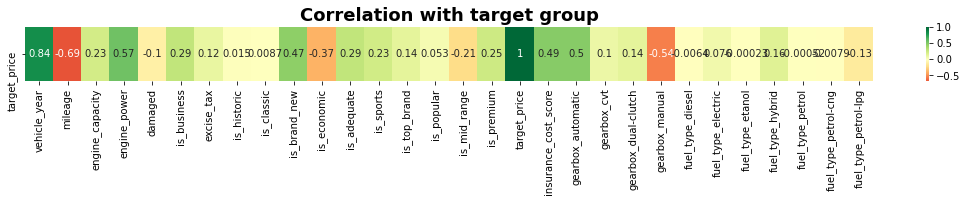

In [58]:
f,ax = plt.subplots(figsize=(19,1))
sns.heatmap(spe_corr.sort_values(by=['target_price'], ascending=False).head(1), cmap='RdYlGn', center=0, annot=True)
plt.title("Correlation with target group", weight='bold', fontsize=18)

plt.show()

Looks like most features are actually somewhat important, just a few have less than 10% correlation with target price. Now, for a good measure, we can also look at correlation across the whole data.

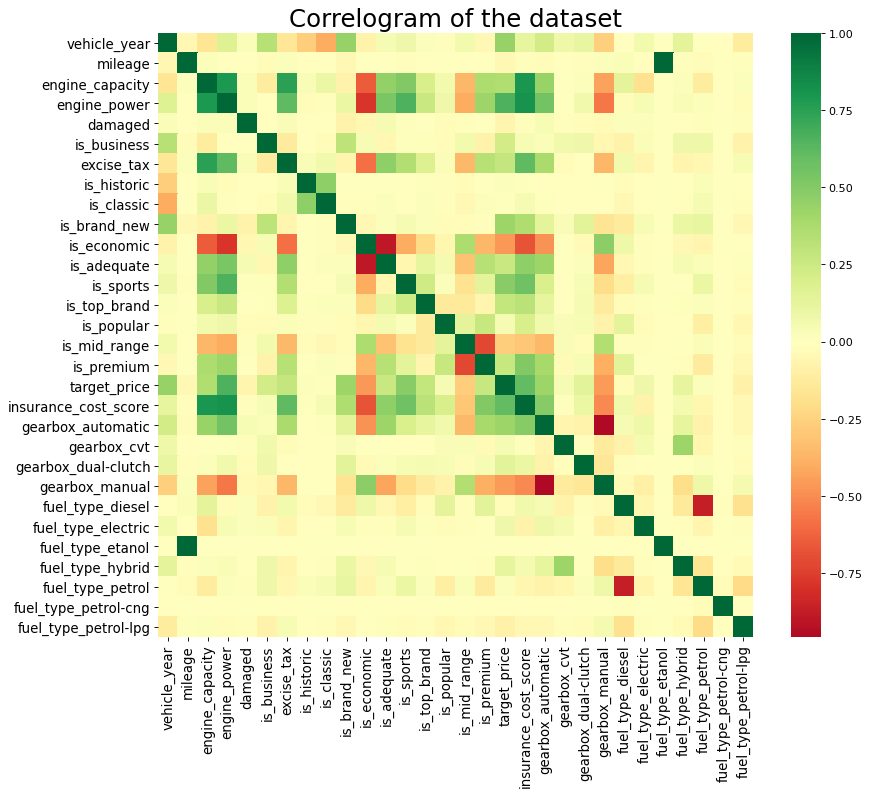

In [59]:
draw_correlogram(raw_data, corr_values=False)

Unsurprisingly, there some clusters of higher correlation between new features and ones used to engineer them.

As a next step, let's run a default model over our data to see which features are the most important. While a pretty basic way of establishing feature importance, it's not the only thing we look at here, so we're more than fine. Once again, with a couple of other methods and visualizations, sholud give us a pretty good idea what to look for and concentrate on.

In [60]:
default_lgbm_model = LGBMRegressor(n_jobs=-1)

In [61]:
y_raw_data = raw_data['target_price']
x_raw_data = raw_data.drop(columns=['target_price', 'make', 'model'], inplace=False)

In [62]:
fitted_default = default_lgbm_model.fit(x_raw_data, y_raw_data)

In [63]:
feat_importance = pd.DataFrame((sorted(zip(x_raw_data.columns, fitted_default.feature_importances_))), 
                               columns=['feature', 'feature_importance'])
feat_importance.sort_values(by='feature_importance', ascending=False).head(15)

,feature,feature_importance
2,engine_power,897
1,engine_capacity,464
15,insurance_cost_score,376
27,mileage,364
28,vehicle_year,354
0,damaged,108
26,is_top_brand,86
24,is_premium,48
18,is_business,47
8,fuel_type_petrol,46


Looks like the default model favors engine related features as well as mileage and vehicle year, which at a quick glance makes sense, since these are the real differentiating factors in the data we have, as mot many cars have big engines and lots of power nowadays.

In [64]:
# 'make', 'model',

features = ['vehicle_year', 'mileage', 'engine_capacity', 'engine_power', 'damaged', 
            'is_business', 'excise_tax', 'is_historic', 'is_classic', 'is_brand_new', 
            'is_economic', 'is_adequate', 'is_sports', 'is_top_brand', 'is_popular', 
            'is_mid_range', 'is_premium', 'target_price', 'insurance_cost_score', 
            'gearbox_automatic', 'gearbox_cvt', 'gearbox_dual-clutch', 'gearbox_manual', 
            'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_etanol', 'fuel_type_hybrid', 
            'fuel_type_petrol', 'fuel_type_petrol-cng', 'fuel_type_petrol-lpg']

selected_data = raw_data[features]

Now that we have our features, let's randomly shuffle the data and split it into train and test sets, separating our target variable (train_test_split already shuffles data for us). 

In [65]:
x_train, x_test, y_train, y_test = train_test_split(selected_data.drop(columns='target_price', inplace=False), 
                                                    selected_data['target_price'], test_size=0.2,
                                                    random_state=RAND_SEED)

While we could (and in many instances would) apply log transformation to the target variable, since as we saw earlier it transforms the data to be almost perfectly normally distributed, in the end it wasn't neccessary and performance improvements were negligible.

In [66]:
# y_train = np.log1p(y_train)
# y_test = np.log1p(y_test)

In [67]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((164965, 29), (41242, 29), (164965,), (41242,))

## Training and choosing a model

While there are many possible algorithms we could use (and I certainly did use them in the past), such as neural networks, model stacking/blending or even using neural networks as meta-learners, I settled on **ridge** and **lasso regression** which are simple models we could use as a baseline and **gradient boosting** which is most commonly used for its speed and performance. I chose **LightGBM** in particular, since it's more customizable than **XGBoost** and it builds and splits trees more efficiently (thanks in part to using depth-first search, instead of breadth-first search like XGBoost) than comparable algorithms. Ultimately, if I had more time, I would definitely use **CatBoost** in conjunction with categorical features, since more often than not it produces good results, but perhaps that's a task for another day.

Keep in mind, my ultimate goal wasn't finding and tweaking any given model for the best performance possible, but rather exploring different scenarios and seeing how different decisions might impact the model as I could have easily spent another day or two just messing with hyperparamters to squeeze out every drip of performance.

One final thing to note; while I would normally opt for cross-validation or given enough time parameter search (most likely bayes or random search), I doubt we would be seeing something unusual and trying a couple of models in a couple of folds can get long really quick - I'd rather spend my time trying other methods and techniques, not on waiting. 

In [68]:
ridge_model = Ridge(alpha=0.5, normalize=True)
lasso_model = Lasso(alpha=0.2, normalize=True)

lgbm_model = LGBMRegressor(n_jobs=-1)
larger_lgbm_model = LGBMRegressor(objective='regression', learning_rate=0.1, max_depth=40, 
                                  num_leaves=200, n_estimators=400, silent=True)

In [69]:
ridge_model.fit(x_train, y_train)
lasso_model.fit(x_train, y_train)

lgbm_model.fit(x_train, y_train)
larger_lgbm_model.fit(x_train, y_train)

LGBMRegressor(max_depth=40, n_estimators=400, num_leaves=200,
              objective='regression')

In order for the linear models to work better, we would have to both normalize the data and make sure it's normally distributed - but they aren't the focus anyways, so what we have here is fine.

## Model performance analysis

Now, let's analyze our models' performance.

To properly address the performance, and see the big picture, we could use a couple of metrics, rather than focusing on a single one. While in classification tasks, the metric choice is highly dependent on the task at hand and our focus, in the case of regression it's pretty straightforward. We'll look at: **MAE**, **RMSE** and **R2**.

Both MAE and RMSE express average model prediction error in interpretable units and are indifferent to the direction of errors. However RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. 

Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable.

Later on, we'll also take a look at a couple of summary statistics regarding our errors and a few good and bad predictions - trying to understand why model performed the way it did and what's the root cause. Feature analysis is also coming up.

In [70]:
def evaluate_predictions(model):
    model_predictions = model.predict(x_test)
    print(f"{model.__class__.__name__}")
    print('y_test standard deviation: %.3f' % (y_test.std()))
    print('MAE: %.3f' % mean_absolute_error(y_test, model_predictions))
    print('RMSE: %.3f' % math.sqrt(mean_squared_error(y_test, model_predictions)))
    print('R2: %.3f' % r2_score(y_test, model_predictions))

In [76]:
evaluate_predictions(ridge_model)

Ridge
y_test standard deviation: 87058.477
MAE: 21658.638
RMSE: 50643.260
R2: 0.662


In [77]:
evaluate_predictions(lasso_model)

Lasso
y_test standard deviation: 87058.477
MAE: 21877.217
RMSE: 46258.088
R2: 0.718


In [71]:
evaluate_predictions(lgbm_model)

LGBMRegressor
y_test standard deviation: 87058.477
MAE: 10619.427
RMSE: 29640.900
R2: 0.884


In [72]:
evaluate_predictions(larger_lgbm_model)

LGBMRegressor
y_test standard deviation: 87058.477
MAE: 8964.093
RMSE: 28207.828
R2: 0.895


While simple linear models with different regularisation terms weren't too good at predicting the prices, even the default LightGBM model was performing nicely and given a few hyperparameter tweaks improved it's performance to satisfactory levels. 

## In-depth look at predictions

Let's take a closer look at the model's predictions to understand where we could improve and what was problematic for our model. First, we'll create a simple dataframe with both predicted and actual prices.

In [73]:
y_pred = larger_lgbm_model.predict(x_test)
helper_dict = {'actual_price': y_test, 'predicted_price': y_pred, 'error':abs(y_test-y_pred), 
               'pct_difference': ((abs(y_test-y_pred) / y_test)*100)}
summary_df = pd.DataFrame(data=helper_dict)

In [74]:
summary_df.head(5)

,actual_price,predicted_price,error,pct_difference
41496,42000.0,47653.417767,5653.417767,13.460518
120710,16990.0,15509.108258,1480.891742,8.716255
38747,29900.0,36327.229995,6427.229995,21.495752
20756,26800.0,30270.652990,3470.652990,12.950198
94950,23500.0,21866.012315,1633.987685,6.953139


In [75]:
summary_df['pct_difference'].describe()

count    41242.000000
mean        19.233165
std         40.203210
min          0.000968
25%          5.379204
50%         11.721874
75%         21.989042
max       4477.283178
Name: pct_difference, dtype: float64

A quick look at summary statistics tells us, that on average we're off with our predictions by 19.2%. With a glance at median we know that in case of half of our predictions, we were off by 11.7% or less, which I think is not that bad. Keep in mind, I didn't end up removing any outliers from the `target_price` column, and there are certainly lots of instances where the price is a placeholder, e.g. 12345, 99999, etc. These records could be easily filtered out before making predictions if need be. 

Let's take a look at our best and worst predictions to try and see why the model did what it did.

In [76]:
summary_df.sort_values(by=['pct_difference']).head(10)

,actual_price,predicted_price,error,pct_difference
351,12900.0,12899.875184,0.124816,0.000968
51098,93900.0,93898.989210,1.010790,0.001076
193028,75900.0,75899.067314,0.932686,0.001229
49171,152000.0,152002.104403,2.104403,0.001384
68370,119800.0,119798.116775,1.883225,0.001572
61247,249000.0,249004.931411,4.931411,0.001980
144897,23900.0,23899.438146,0.561854,0.002351
82428,14900.0,14899.644456,0.355544,0.002386
52673,144900.0,144896.467980,3.532020,0.002438
3170,46300.0,46298.511824,1.488176,0.003214


In [77]:
raw_data.iloc[51098, :6]

make                 audi
model                  a7
vehicle_year         2014
mileage            166000
engine_capacity      3000
engine_power          333
Name: 51098, dtype: object

It's pretty clear that our model performs best in case of cars that are somewhat in the middle of the pack.

In [78]:
summary_df.sort_values(by=['pct_difference'], ascending=False).head(10)

,actual_price,predicted_price,error,pct_difference
205819,1234.0,56483.674419,55249.674419,4477.283178
55768,900.0,10418.562101,9518.562101,1057.618011
76711,14900.0,169016.885687,154116.885687,1034.341515
6107,3900.0,41690.271807,37790.271807,968.981328
184799,900.0,9268.632703,8368.632703,929.848078
67424,25000.0,252561.769564,227561.769564,910.247078
318,4900.0,47324.046331,42424.046331,865.796864
197455,3990.0,37836.024509,33846.024509,848.271291
87665,2000.0,17068.947145,15068.947145,753.447357
168855,1350.0,11279.554422,9929.554422,735.522550


In [79]:
raw_data.iloc[67424, :6]

make               lamborghini
model                 gallardo
vehicle_year              2005
mileage                  60000
engine_capacity           4961
engine_power               500
Name: 67424, dtype: object

In this instance, the person creating the posting clearly made a mistake regarding the price.

In [80]:
raw_data.iloc[76711, :6]

make               land-rover
model                defender
vehicle_year             1971
mileage                 50000
engine_capacity          2000
engine_power              111
Name: 76711, dtype: object

Here on the other hand, our model falsely assumed that the land-rover was a luxury vehicle, when in fact defenders from the 70s are rugged SUVs that became pretty affordable. Their prices are rising though, according to the enthusiast market.

## Feature analysis

In [81]:
fitted_default = larger_lgbm_model.fit(x_train, y_train)
feat_importance = pd.DataFrame((sorted(zip(x_train.columns, fitted_default.feature_importances_))), columns=['feature', 'feature_importance'])
feat_importance.sort_values(by='feature_importance', ascending=False).head(15)

,feature,feature_importance
27,mileage,21671
2,engine_power,17525
28,vehicle_year,11057
1,engine_capacity,10929
15,insurance_cost_score,9291
18,is_business,1612
23,is_popular,1139
11,gearbox_automatic,919
4,fuel_type_diesel,776
8,fuel_type_petrol,719


Looks like according to LightGBM's feature importance, by far the most important were mileage and engine_power, confirming our suspicions regarding strong engines being real difference makers, since not many of them sell these days. In addition, vehicle_year and our mock insurance score also had a noticeably bigger impact than other features.

Next, we'll use Shapley values and game theory to establish better quality feature importance. While in general, a nice way of explaining a model, we have to keep in mind that it's not infallible, and an experienced data scientist would definitely be able to manipulate its results, as presented in this paper: [Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods](https://arxiv.org/abs/1911.02508). Furhermore, we won't be using LIME, as the number of features is not that high.

Unfortunately due to a  bug which I wasn't able to identify for sure (most likely too wide range for the target variable), the SHAP values are unnaturally large. However for the purpose of this analysis (and in general most of the time), we don't interpret them on their own but relatively to other features and to know how much impact a given feature and its values have, so we're fine.

In [83]:
explainer = shap.TreeExplainer(fitted_default, x_train)
shap_values = explainer(shap.sample(x_test, 500))

 99%|===================| 494/500 [00:19<00:00]        

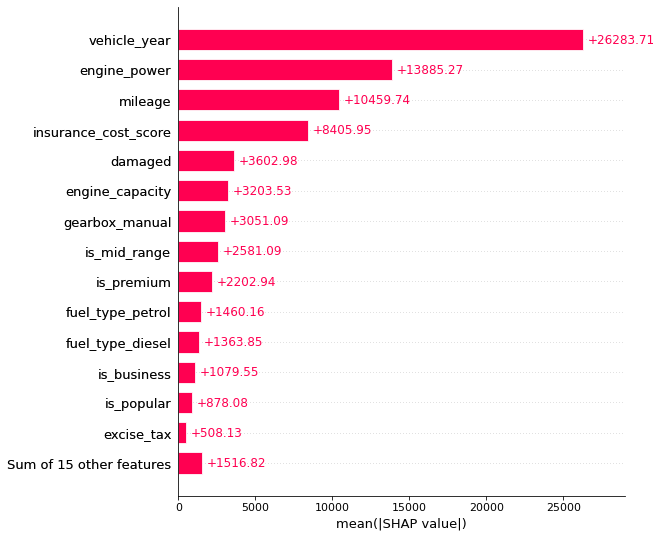

In [84]:
shap.plots.bar(shap_values, max_display=15)

Looks like in this case, there should be no surprises, since some of these features also were considered to have the most influence (just to a different degree). By far the most important to the analyzed sample was vehicle_year feature. Engine power, mileage and insurance_cost_score also stand out as being far more influential than others.

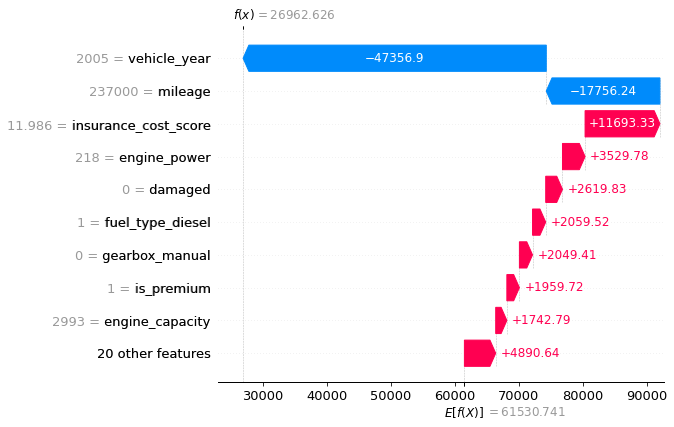

In [85]:
shap.plots.waterfall(shap_values[1])

In this example we observe feature values of a given instance. Here, the year 2005 really drags the value of the vehicle down, same with the mileage (237K) which is really high. We know that the mock insurance cost helps the value of the car, and that's in part thanks to it being a premium make and having a strong engine. 

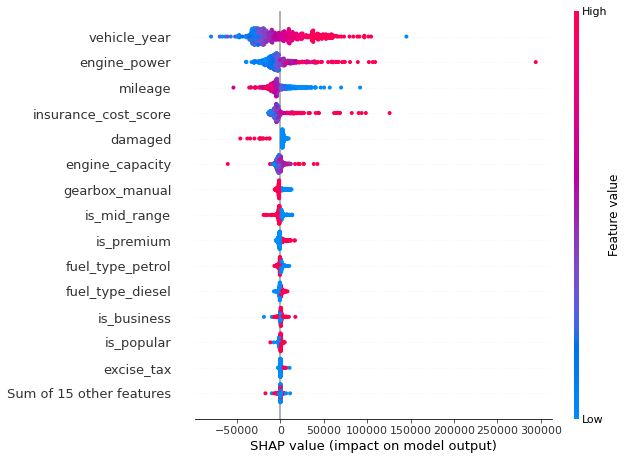

In [86]:
shap.plots.beeswarm(shap_values, max_display=15)

Now, looking at the plot above, we can observe some interesting but somewhat expected results. A few key takeaways:
- the higher the value of vehicle_year (the newer the car), the better,
- the more powerful the engine, the bigger impact it has on the price; weaker engines make the price go lower,
- as the mileage decreases, the price increases,
- high mock insurance cost generally indicates high vehicle price, which makes sense, since it takes into account a few other features such as engine, make, how new the car is, etc.
- damaged cars (binary feature), generally speaking, take a big hit on the price. 

## Summary and final words

### Conclusion

In the end, the **final model performed well**, even with outliers in place, achieved good performance at the same time explaining a lot of variance in the data. For the sake of keeping the model lightweight, we didn't even include make and model as features, but rather used them to produce new features capturing the relationships in data. 

All the null values were imputed and numerous corrections to the wrongly filled data were made; during the process of data preprocessing, everything was done at the cost of **no data loss**. 

While I didn't test the impact of imputation and correction of wrong values on model's performance, I did in fact check how much difference our new features made. When our features weren't present in the model, the MAE rose by around 700 (**7.8%**), RMSE rose by over 920 (**3.2%**). On average, we were off with our predictions by **1.2%** more. I'm confident that if the imputation and corrections weren't applied, the model's performance would have deteriorated further.

We didn't remove any outliers, making use of all the data we could and most of the null and outlier values were imputed by either 0s, mean or most frequent values within a specific subgroup. Furthermore, outlier instances in target_price class **can be filtered out easily**; one option is to look for placeholder prices, e.g. 123456, 99999, etc.; second option is to traverse the data and calculate 2 or 3 times the median average price for a given model, engine and year combination and get rid of instances not within the range.



### Sales strategy

Given the nature of the problem, the team should focus on selling the biggest movers at the cost of low margins to build stronger relationships with suppliers and manufacturers. Furthermore, I'm highly confident in the model's performance when it comes to mid-range and premium cars. Given enough time and continuous sales improvement, the group could eventually expand the offer by selling luxury and sports cars, where higher margins are possible. 

### What would I do next?

While many improvements could certainly be made here, probably the most impactful would be either additional features, such as vehicle's equipment, it's body type and drivetrain information. Furthermore, having an actual description of the ad could help identify standout features by using even very simple NLP algorithms.

Given my previous experience with Otodom data, I'm pretty sure that using NLP would yield great results, e.g. utilising n-grams to find additional equipment information.  

Filtering out outliers could also be beneficial to the model's performance and as mentioned before, wouldn't take too much effort as similar techniques were incorporated in value correction throughout the notebook.

Knowing when the date of ad posting and how long it took till sale could be indicative of what the **true** value is; being online too short could mean the price was too low, vice versa. Additionally, there's definitely some seasonality involved and other market conditions that could influence prices and buyers' behavior. One such example could be end of year, when a lot of company cars are being bought due to nearing tax fillings.

Additionally, there's a lot of functionality that could be added to users as well (although some might be a little overkill and should stay a trade secret), e.g.:
- an indication on what the buyers and people browsing the site pay attention to the most; what terms are being searched, additional equipment that's popular - to help the seller,
- something similar to above, but for the buyer, where pop-ups or blog-post like tutorials could help first-time buyers choose what's right for them,
- actual car insurance calculator in partnership with other companies (the same way loans currently work with ComperiaRaty)
- some kind of listing hotness score, where number of views, clicks in general, private messages sent, reveal phone number buttons clicked





That's it, hope You made it to the end and liked what You saw, because I certainly had a good time working on it :) 